In [18]:
import pandas as pd
import numpy as np 
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.applications.resnet_v2 import ResNet50V2

from tensorflow.keras.utils import  img_to_array
from tensorflow.keras.preprocessing.image import load_img
from keras.models import Sequential 
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense 
from keras import applications 
from keras.utils.np_utils import to_categorical 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import tensorflow as tf

%matplotlib inline
import math 
import itertools, re, os, random, keras
import plotly.express as px
import datetime
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import time

In [19]:
train_path ='C:\\Users\\Dell\\Birds - Copy\\train'
valid_path ='C:\\Users\\Dell\\Birds - Copy\\valid'
test_path ='C:\\Users\\Dell\\Birds - Copy\\test'

In [20]:
import os
import shutil
import random

data_path = 'C:\\Users\\Dell\\Birds - Copy\\train'
train_path = 'C:\\Users\\Dell\\Birds - Copy\\train_split\\train'
val_path = 'C:\\Users\\Dell\\Birds - Copy\\train_split\\val'
test_path = 'C:\\Users\\Dell\\Birds - Copy\\train_split\\test'

# Define the split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Loop through each class folder in the data_path
for class_name in os.listdir(data_path):
    class_path = os.path.join(data_path, class_name)
    filenames = os.listdir(class_path)
    random.shuffle(filenames)
    
    # Split the filenames into train, validation, and test sets
    num_files = len(filenames)
    train_cutoff = int(num_files * train_ratio)
    val_cutoff = int(num_files * (train_ratio + val_ratio))
    train_filenames = filenames[:train_cutoff]
    val_filenames = filenames[train_cutoff:val_cutoff]
    test_filenames = filenames[val_cutoff:]
    
    # Copy the train files to the train directory
    for filename in train_filenames:
        src_path = os.path.join(class_path, filename)
        dst_path = os.path.join(train_path, class_name, filename)
        os.makedirs(os.path.join(train_path, class_name), exist_ok=True)
        shutil.copy(src_path, dst_path)
        
    # Copy the validation files to the validation directory
    for filename in val_filenames:
        src_path = os.path.join(class_path, filename)
        dst_path = os.path.join(val_path, class_name, filename)
        os.makedirs(os.path.join(val_path, class_name), exist_ok=True)
        shutil.copy(src_path, dst_path)
        
    # Copy the test files to the test directory
    for filename in test_filenames:
        src_path = os.path.join(class_path, filename)
        dst_path = os.path.join(test_path, class_name, filename)
        os.makedirs(os.path.join(test_path, class_name), exist_ok=True)
        shutil.copy(src_path, dst_path)


In [21]:
def ploti(train_path,which):
    directory=os.listdir(train_path)
    train=pd.DataFrame(directory,columns=['folders'])
    counts=[]
    for i in directory:
        path=train_path+'\\'+i
        num_files = len([f for f in os.listdir(path)if os.path.isfile(os.path.join(path, f))])
        counts.append(num_files)
    train['counts']=counts
    fig = px.pie(train, values='counts', names='folders', title='distribution across '+str(which))
    fig.show()

In [22]:
ploti(train_path,'Train')
ploti(val_path,"Validation")
ploti(test_path,"test")

In [23]:
def plotImagesAndLabels(folder):
    c=1
    directory=os.listdir(folder)
    plt.figure(figsize=(28,20))
    for each in directory:
        currentFolder=folder+ "\\" +each
        for i, file in enumerate(os.listdir(currentFolder)[0:4]):
            full_path=currentFolder+"\\"+file
            plt.subplot(3, 8, c)
            img = mpimg.imread(full_path)
            plt.imshow(img)
            plt.title(each)
            c+=1
    plt.subplots_adjust(wspace=0.3, hspace=-0.1)
    plt.show()

Lets see some samples from training data...


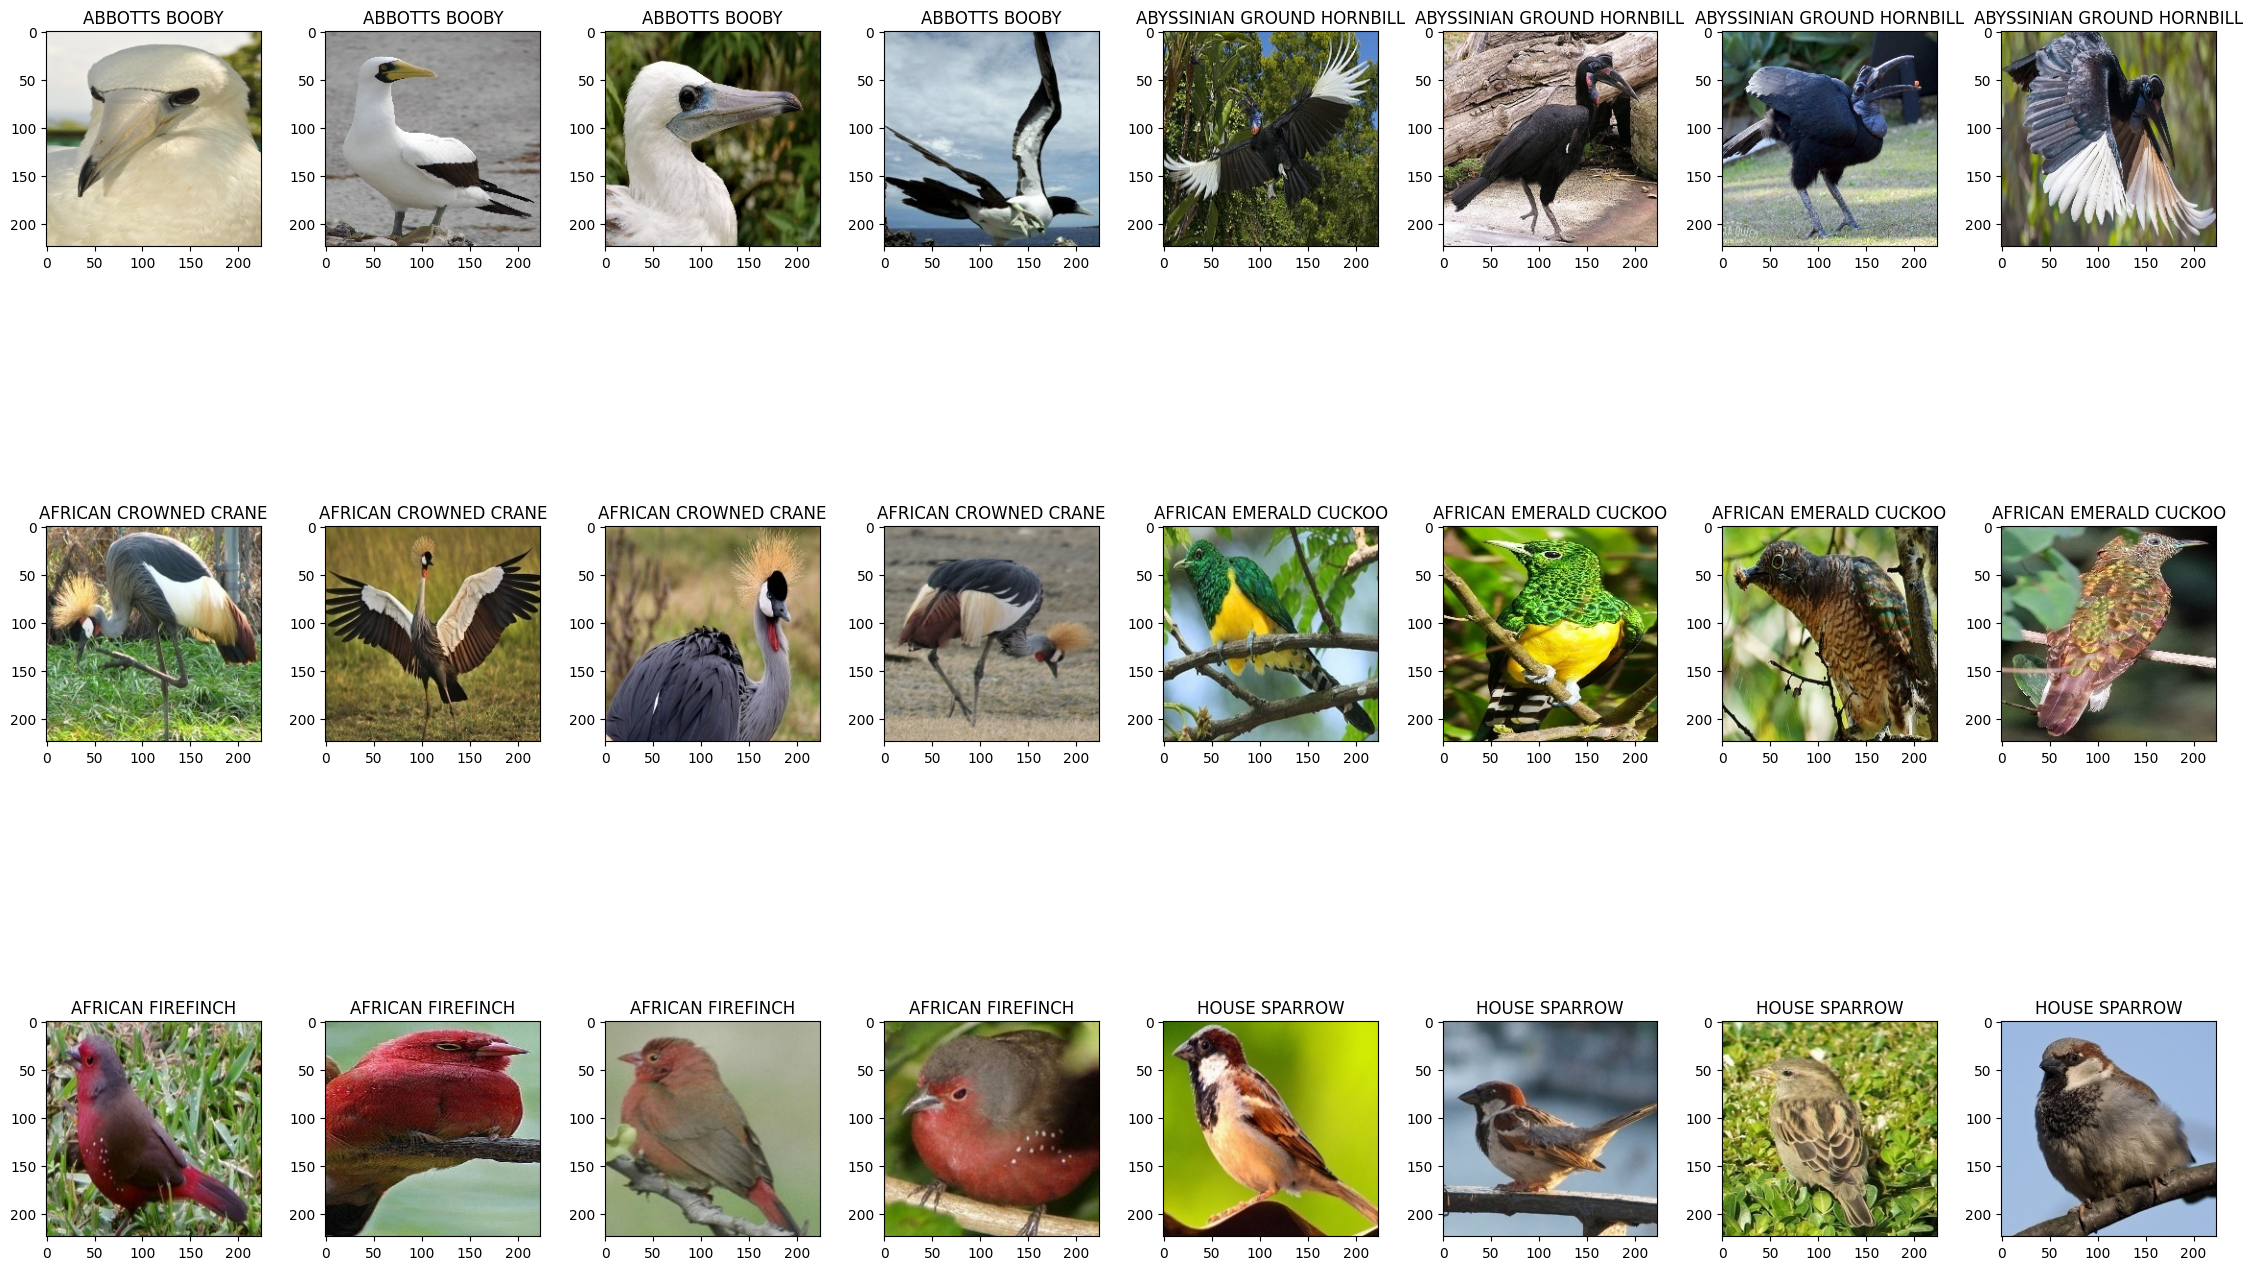

In [24]:
print("Lets see some samples from training data...")
plotImagesAndLabels(train_path)

In [25]:
#Default dimensions we found online
img_width, img_height = 224, 224 
 
#Create a bottleneck file
top_model_weights_path = 'bottleneck_fc_model_ResNet50V2.h5'

# loading up our datasets
train_data_dir = 'C:\\Users\\Dell\\Birds - Copy\\train_split\\train'
validation_data_dir = 'C:\\Users\\Dell\\Birds - Copy\\train_split\\val'
test_data_dir = 'C:\\Users\\Dell\\Birds - Copy\\train_split\\test'
 
# number of epochs to train top model 
epochs = 15 #this has been changed after multiple model run 
# batch size used by flow_from_directory and predict_generator 
batch_size = 30

In [70]:
#Loading ele3b brahtk model
from keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator

VGG19_model = VGG19(include_top=False, weights='imagenet')
for layer in VGG19_model.layers:
    layer.trainable = False

datagen = ImageDataGenerator(rescale=1. / 255)

#needed to create the bottleneck .npy files

In [71]:
#__this can take an hour and half to run so only run it once. 
#once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__
from keras.applications.resnet_v2 import ResNet50V2

start = datetime.datetime.now()
 
generator = datagen.flow_from_directory( 
    train_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode=None, 
    shuffle=False) 
 
nb_train_samples = len(generator.filenames) 
num_classes = len(generator.class_indices) 
 
predict_size_train = int(math.ceil(nb_train_samples / batch_size)) 
 
bottleneck_features_train = VGG19_model.predict_generator(generator, predict_size_train) 
 
np.save('bottleneck_features_train_VGG19_model.npy', bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 940 images belonging to 6 classes.


C:\Users\Dell\AppData\Local\Temp\ipykernel_19692\2352795746.py:19: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



Time:  0:01:49.145248


In [72]:
start = datetime.datetime.now()
 
generator = datagen.flow_from_directory( 
   validation_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode=None, 
    shuffle=False) 
 
nb_train_samples = len(generator.filenames) 
num_classes = len(generator.class_indices) 
 
predict_size_train = int(math.ceil(nb_train_samples / batch_size)) 
 
bottleneck_features_valid = VGG19_model.predict_generator(generator, predict_size_train) 
 
np.save('bottleneck_features_valid_VGG19_model.npy', bottleneck_features_valid)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 261 images belonging to 6 classes.


C:\Users\Dell\AppData\Local\Temp\ipykernel_19692\1473059510.py:15: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



Time:  0:00:31.355732


In [73]:
start = datetime.datetime.now()
 
generator = datagen.flow_from_directory( 
   test_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode=None, 
    shuffle=False) 
 
nb_train_samples = len(generator.filenames) 
num_classes = len(generator.class_indices) 
 
predict_size_train = int(math.ceil(nb_train_samples / batch_size)) 
 
bottleneck_features_test = VGG19_model.predict_generator(generator, predict_size_train) 
 
np.save('bottleneck_features_test_VGG19_model.npy', bottleneck_features_test)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 256 images belonging to 6 classes.


C:\Users\Dell\AppData\Local\Temp\ipykernel_19692\2666070133.py:15: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



Time:  0:00:29.482150


In [74]:
#training data
generator_top = datagen.flow_from_directory( 
   train_data_dir, 
   target_size=(img_width, img_height), 
   batch_size=batch_size, 
   class_mode='categorical', 
   shuffle=False) 
 
nb_train_samples = len(generator_top.filenames) 
num_classes = len(generator_top.class_indices) 
 
# load the bottleneck features saved earlier 
train_data = np.load('bottleneck_features_train_VGG19_model.npy') 
 
# get the class labels for the training data, in the original order 
train_labels = generator_top.classes 
 
# convert the training labels to categorical vectors P
train_labels = to_categorical(train_labels, num_classes=num_classes)

Found 940 images belonging to 6 classes.


In [75]:
generator_top = datagen.flow_from_directory( 
   validation_data_dir, 
   target_size=(img_width, img_height), 
   batch_size=batch_size, 
   class_mode='categorical', 
   shuffle=False) 
 
nb_train_samples = len(generator_top.filenames) 
num_classes = len(generator_top.class_indices) 
 
# load the bottleneck features saved earlier 
valid_data = np.load('bottleneck_features_valid_VGG19_model.npy') 
 
# get the class labels for the training data, in the original order 
valid_labels = generator_top.classes 
 
# convert the training labels to categorical vectors 
valid_labels = to_categorical(valid_labels, num_classes=num_classes)

Found 261 images belonging to 6 classes.


In [76]:
generator_top = datagen.flow_from_directory( 
   test_data_dir, 
   target_size=(img_width, img_height), 
   batch_size=batch_size, 
   class_mode='categorical', 
   shuffle=False) 
 
nb_train_samples = len(generator_top.filenames) 
num_classes = len(generator_top.class_indices) 
 
# load the bottleneck features saved earlier 
test_data = np.load('bottleneck_features_test_VGG19_model.npy') 
 
# get the class labels for the training data, in the original order 
test_labels = generator_top.classes 
 
# convert the training labels to categorical vectors 
test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 256 images belonging to 6 classes.


In [77]:
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image

#This is the best model we found.
start = datetime.datetime.now()
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(224,
                                  224,
                                  3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
    layers.RandomTranslation(0.2, 0.2),
  ]
)

model = Sequential() 
model.add(Flatten(input_shape=train_data.shape[1:])) 
model.add(Dense(200, activation=keras.layers.LeakyReLU(alpha=0.3)))
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3))) 
model.add(Dropout(0.75)) 
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3)))
model.add(Dropout(0.5)) 
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
   optimizer=optimizers.RMSprop(lr=1e-4),
   metrics=['acc'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('resnet.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True, patience=10)

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

history = model.fit(train_datagen.flow(train_data, train_labels, batch_size=batch_size),
   epochs=100,
   batch_size=batch_size, 
   validation_data=(valid_data, valid_labels),
   callbacks=[es,mc])
model.save_weights(top_model_weights_path)

(eval_loss, eval_accuracy) = model.evaluate( 
    valid_data, valid_labels, batch_size=batch_size, verbose=1)
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("[INFO] Loss: {}".format(eval_loss)) 

end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)


C:\Users\Dell\anaconda3\envs\birds\lib\site-packages\keras\preprocessing\image.py:680: UserWarning:

NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (940, 7, 7, 512) (512 channels).



Epoch 1/100
32/32 [==============================] - ETA: 0s - loss: 1.7899 - acc: 0.1851
Epoch 1: val_loss improved from inf to 3.93834, saving model to resnet.h5
32/32 [==============================] - 13s 388ms/step - loss: 1.7899 - acc: 0.1851 - val_loss: 3.9383 - val_acc: 0.1954
Epoch 2/100
32/32 [==============================] - ETA: 0s - loss: 1.7847 - acc: 0.1926
Epoch 2: val_loss did not improve from 3.93834
32/32 [==============================] - 12s 368ms/step - loss: 1.7847 - acc: 0.1926 - val_loss: 5.1101 - val_acc: 0.2567
Epoch 3/100
32/32 [==============================] - ETA: 0s - loss: 1.7827 - acc: 0.1904
Epoch 3: val_loss did not improve from 3.93834
32/32 [==============================] - 12s 366ms/step - loss: 1.7827 - acc: 0.1904 - val_loss: 7.4798 - val_acc: 0.1954
Epoch 4/100
32/32 [==============================] - ETA: 0s - loss: 1.7786 - acc: 0.2245
Epoch 4: val_loss did not improve from 3.93834
32/32 [==============================] - 12s 367ms/step - l

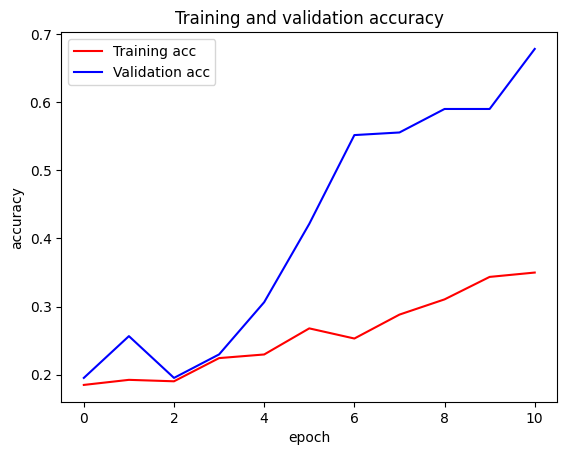

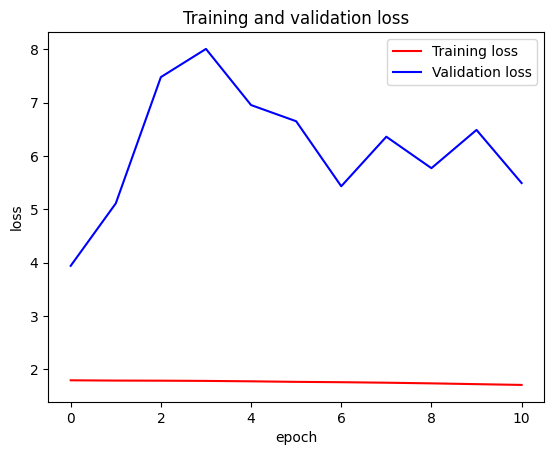

In [78]:
#Graphing our training and validation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()

In [79]:
model.evaluate(test_data,test_labels)

8/8 [==============================] - 0s 6ms/step - loss: 5.5589 - acc: 0.6875


[5.558860778808594, 0.6875]

In [80]:
preds=np.round(model.predict(test_data),0)
print('rounded test_labels',preds)

8/8 [==============================] - 0s 5ms/step
rounded test_labels [[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]


In [81]:
birds=['ABBOTTS BOOBY', 'ABYSSINIAN GROUND HORNBILL', 'AFRICAN CROWNED CRANE', 'AFRICAN EMERALD CUCKOO','AFRICAN FIREFINCH','HOUSE SPARROW']
classification_metrics=metrics.classification_report(test_labels,preds,target_names=birds)
print(classification_metrics)

                            precision    recall  f1-score   support

             ABBOTTS BOOBY       0.58      0.86      0.69        49
ABYSSINIAN GROUND HORNBILL       0.69      0.92      0.79        48
     AFRICAN CROWNED CRANE       1.00      0.63      0.77        38
    AFRICAN EMERALD CUCKOO       0.82      0.63      0.71        43
         AFRICAN FIREFINCH       0.00      0.00      0.00        37
             HOUSE SPARROW       0.62      0.95      0.75        41

                 micro avg       0.69      0.69      0.69       256
                 macro avg       0.62      0.66      0.62       256
              weighted avg       0.63      0.69      0.63       256
               samples avg       0.69      0.69      0.69       256



C:\Users\Dell\anaconda3\envs\birds\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Confusion matrix, without normalization


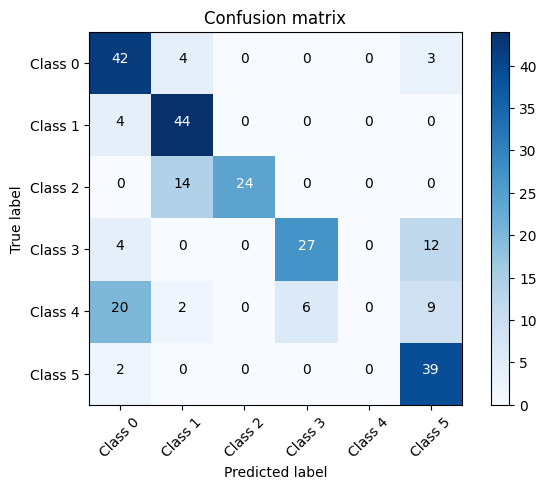

In [95]:
from sklearn.metrics import confusion_matrix
import itertools

categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)
conf_mat = confusion_matrix(categorical_test_labels, categorical_preds)

#To get better visual of the confusion matrix:
def plot_confusion_matrix(cm, classes,
   normalize=False,
   title='Confusion matrix',
   cmap=plt.cm.Blues):
 
#Add Normalization Option
 
   if normalize:
     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
     print("Normalized confusion matrix")
   else:
     print('Confusion matrix, without normalization')
 
# print(cm)
 
   plt.imshow(cm, interpolation='nearest', cmap=cmap)
   plt.title(title)
   plt.colorbar()
   tick_marks = np.arange(len(classes))
   plt.xticks(tick_marks, classes, rotation=45)
   plt.yticks(tick_marks, classes)
 
   fmt = '.2f' if normalize else 'd'
   thresh = cm.max() / 2.
   for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
 
   plt.tight_layout()
   plt.ylabel('True label')
   plt.xlabel('Predicted label')

plot_confusion_matrix(conf_mat, classes = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'])


Normalized confusion matrix


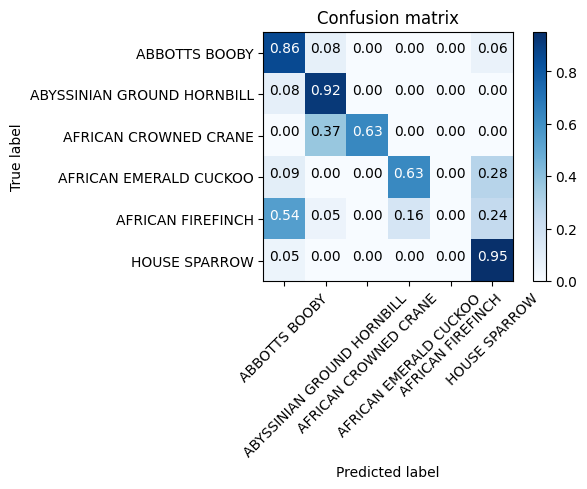

In [92]:
cm_plot_labels=['ABBOTTS BOOBY', 'ABYSSINIAN GROUND HORNBILL', 'AFRICAN CROWNED CRANE', 'AFRICAN EMERALD CUCKOO','AFRICAN FIREFINCH','HOUSE SPARROW']
conf_mat = confusion_matrix(categorical_test_labels, categorical_preds)
plot_confusion_matrix(conf_mat, cm_plot_labels, normalize=True)


In [89]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 25088)             0         
                                                                 
 dense_24 (Dense)            (None, 200)               5017800   
                                                                 
 dense_25 (Dense)            (None, 100)               20100     
                                                                 
 dropout_12 (Dropout)        (None, 100)               0         
                                                                 
 dense_26 (Dense)            (None, 100)               10100     
                                                                 
 dropout_13 (Dropout)        (None, 100)               0         
                                                                 
 dense_27 (Dense)            (None, 6)               

In [91]:
VGG19_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     